Let's begin by selecting the atlas from your local file system.  If you're running this notebook locally, you should be able to navigate to the appropriate folder using the file chooser interface below without any special setup (beyond installation of the relevant packages).

However, if you're using a [jupyterlab](https://jupyter.org/) [binder](https://mybinder.org/), there's an extra step to making your data avaialble to this interface.  In order to do this, you'll need to upload your data to this virtual environment.  NOTE: because this is a temporary virtual environment, any data that you upload here will not be preserved.  All the same, it is best to be careful about what data is uploaded.  To upload data to this [jupyterlab](https://jupyter.org/) environment Click the **file icon** in the **left hand menu**, then click the **underlined up arrow** to begin the upload selection.

Alternatively, if you're using a classic jupyter-notebook [binder](https://mybinder.org/) (acheived by clicking **Launch Classic Notebook** under the help menu, and temporarily reccomended until widget interfacing has been fixed in jupyterlab) click the **upload** button and upload the files below, and then select this notebook (InteractiveWhiteMatterSegmentation.ipynb) and proceed normally.

For this particular notebook to operate successfully you'll need to upload the following:

- The desired volumetric brain segmentation that will be used to specify brain areas that you wish to view connectivity between (the atlas and the tractrogram should be aligned to one another / in the same space).
- A whole-brain tractogram containing the candidate streamlines you wish to inspect/segment (the atlas and the tractrogram should be aligned to one another / in the same space).
- A lookup table (csv or xls) indicating the human-interpretable identities of the labels in the volumetric brain atlas file.

Once these have been uploaded using the interface on the left hand side of the jupyterlab/binder page, you should be able to access those files in subsequent sections (all on the main/default directory).

In [1]:
#upload widget not working right now, just use path specification for current purposes
#import ipywidgets as widgets
#uploader = widgets.FileUpload()
#uploader

#set path to atlas
from ipyfilechooser import FileChooser
import os

# Create and display a FileChooser widget
# if a file has already been selected, do not revert to no file selected
if 'fcAtlas' in locals():
    #however, if the selected file path is None, do rectify that
    if fcAtlas.selected_path==None:
        print('Please select your input atlas file')
        fcAtlas = FileChooser(os.getcwd())
        display(fcAtlas)
#if it doesn't exist at all (not sure how that would happen) also be sure to rectify that
elif not('fcAtlas' in locals()):
    fcAtlas = FileChooser(os.getcwd())
    print('Please select your input atlas file')
    display(fcAtlas)

Please select your input atlas file


FileChooser(path='D:\Documents\gitDir\monkeyTracts', filename='', title='HTML(value='', layout=Layout(display=…

Now that we have selected the file, let's take a look at it.  Feel free to use the X, Y, and Z sliders to move about the atlas volume.

In [26]:
#conditionally plot the atlas if a file has been chosen.  If not, print warning.
#this might be avoidable with a clever use of observe

import copy
if not(fcAtlas.selected_path==None):
    pathToAtlas=os.path.join(fcAtlas.selected_path,fcAtlas.selected_filename)
    #load the nifti
    import nibabel as nib
    atlasImg = nib.load(pathToAtlas)
    #now relabel it; maybe not necessary with monkey atlases, we'll see

    #in order to have visually distinguishable areas we have to renumber the labels in the data object
    #this is because niwidgets scales the color map via the min and max values of the labeling scheme,
    #rather than by unique values
    #this takes a while to perform, so if it already exists, check, load it, and don't do it again.
    if os.path.isfile('relabeledAtlas.nii.gz'):
        relabeledAtlas = nib.load('relabeledAtlas.nii.gz')
    else:
        #need to make a deep copy, otherwise the relabeling process relabels the origional
        relabeledAtlas=copy.deepcopy(atlasImg.get_fdata())

        #get the unique entries
        import numpy as np
        uniqueAtlasEntries=np.unique(relabeledAtlas).astype(int)

        #iterate across unique label entries
        for iLabels in range(len(uniqueAtlasEntries)):
            #replace the current uniqueAtlasEntries value with the iLabels value
            #constitutes a simple renumbering schema
            relabeledAtlas[relabeledAtlas==uniqueAtlasEntries[iLabels]]=iLabels

        #save to working directory; required as nifitWidget doesn't load from object apparently
        renumberedAtlasNifti=nib.Nifti1Image(relabeledAtlas, atlasImg.affine, atlasImg.header)  
        #save the object down
        nib.save(renumberedAtlasNifti, 'relabeledAtlas.nii.gz')

    from niwidgets import NiftiWidget
    atlas_widget = NiftiWidget('relabeledAtlas.nii.gz')
    atlas_widget.nifti_plotter(colormap='nipy_spectral')
else:
    print('No input atlas file selected.  Please return to previous cell, select an atlas file, and rerun this cell.')

<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=127, continuous_update=False, description='x', max=255), IntSlider(value…

Next we'll select the Lookup table for the atlas you have provided.  The Lookup table provides information about the correspondances of the numerical labels in the atlas file you just provided with the anatomical/conceptual entities they are supposed to designate (as described [here, in a broad manner](https://dannbullock.github.io/WiMSE/notebooks/How_to_interpret_a_volumetric_brain_segmentation.html) and [here, in the context of color lookup tables](https://www.slicer.org/wiki/Documentation/4.1/SlicerApplication/LookupTables).

We will be using an interactive interface with a spreadsheet version of the lookup table in order to select which labels will be required endpoints for our streamlines of interest.  Technically you do not need to provide an Lookup table, as this notebook will peice together a spreadsheet label-selection interface in one is not found, however such an interface will have no terminology-based labeling information and will thus be fairly difficult to interpret or work with. 

In [3]:
if 'fcLUT' in locals():
    #however, if the selected file path is None, do rectify that
    if fcLUT.selected_path==None:
        print('Please select your input Lookup table file')
        fcLUT = FileChooser(os.getcwd())
        display(fcLUT)
#if it doesn't exist at all (not sure how that would happen) also be sure to rectify that
elif not('fcLUT' in locals()):
    fcLUT = FileChooser(os.getcwd())
    print('Please select your input Lookup table file')
    display(fcLUT)

Please select your input Lookup table file


FileChooser(path='D:\Documents\gitDir\monkeyTracts', filename='', title='HTML(value='', layout=Layout(display=…

Lets take a quick look at the LUT that has been provided (or that will be built) using [qgrid](https://github.com/quantopian/qgrid).

In [19]:
#conditionally plot the atlas if a file has been chosen.  If not, build a table from the information in the passed atlas.
#this might be avoidable with a clever use of observe
import pandas as pd
if not(fcLUT.selected_path==None):
    LUTpath=os.path.join(fcLUT.selected_path,fcLUT.selected_filename)
    if fcLUT.selected_filename[-4:]=='.csv':
        LUT=pd.read_csv(LUTpath)
    elif (fcLUT.selected_filename[-4:]=='.xls',fcLUT.selected_filename[-5:]=='.xlsx'):
        LUT=pd.read_excel(LUTpath)
else:
    #build it from the input data
    import numpy as np
    inferredLUTIdentities={'origLabels': np.unique(atlasImg.get_fdata()).astype(int),'newLabels':np.unique(relabeledAtlas).astype(int)}
    LUT=pd.DataFrame(data=inferredLUTIdentities)  

#one way or the other the LUT should now be available
import qgrid
qgrid_firstLUT_widget= qgrid.show_grid(LUT,show_toolbar=True)
qgrid_firstLUT_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Next, let's select the tractogram file.  Due to the [RAM limitations of binder](https://mybinder.readthedocs.io/en/latest/about/about.html#how-much-memory-am-i-given-when-using-binder), it is **strongly** recomend that you limit the size of the uploaded tractogram to less than 1.25 GB.

In [7]:
# Create and display a FileChooser widget
# if a file has already been selected, do not revert to no file selected
if 'fcTractogram' in locals():
    #however, if the selected file path is None, do rectify that
    if fcTractogram.selected_path==None:
        print('Please select your input tractogram file')
        fcTractogram = FileChooser(os.getcwd())
        display(fcTractogram)
#if it doesn't exist at all (not sure how that would happen) also be sure to rectify that
elif not('fcTractogram' in locals()):
    fcTractogram = FileChooser(os.getcwd())
    print('Please select your input tractogram file')
    display(fcTractogram)

Please select your input tractogram file


FileChooser(path='D:\Documents\gitDir\monkeyTracts', filename='', title='HTML(value='', layout=Layout(display=…

Now that you have selected your tractogram, lets interactively view it.

**NOTE**: due to [an ipyvolume idiosyncracy](https://github.com/maartenbreddels/ipyvolume/issues/206) the following visualization widget will begin in an extremely zoomed out state.  Use your middle mouse button (or mouse scroll inteface) to zoom in on the tracrogram visualization)

In [8]:
import nibabel as nib
#conditionally plot the tractogram if a file has been chosen.  If not, print warning.
#this might be avoidable with a clever use of observe
if not(fcTractogram.selected_path==None):   
    tractogramPath=(os.path.join(fcTractogram.selected_path,fcTractogram.selected_filename))
    #compute size and throw warning or error if file size too 
    tractogramGBSize=os.path.getsize(tractogramPath)/(1024*1024*1024)
    if 2>tractogramGBSize>1.25:
        import warnings
        warnings.warn("Input size of tractogram ("+str(tractogramGBSize)+"GB) exceeds recomended value")
    elif tractogramGBSize>2: 
        raise ValueError("Input size of tractogram ("+str(tractogramGBSize)+"GB) exceeds maximum RAM allocation")

    #do a check to see if the selected input file type is supported
    if not(nib.streamlines.is_supported(tractogramPath)):
        raise ValueError("Input tractogram file type not supported")
    else:
        streamsObjIN=nib.streamlines.load(tractogramPath)

    def plotParcellationConnectionWidget(tractogramToPlot):
        #import widget
        from niwidgets import StreamlineWidget
        #set widget object
    
        sw = StreamlineWidget(streamlines=tractogramToPlot.streamlines)
        #set plotting characteristics
        style = {'axes': {'color': 'red',
                      'label': {'color': 'white'},
                      'ticklabel': {'color': 'white'},
                      'visible': False},
             'background-color': 'black',
             'box': {'visible': False}}
        
        #plot it
        #set a viable threshold for how many streamlines to default to plotting
        #likely dependant on available resources and such
        streamThresh=25000
        if len(tractogramToPlot.streamlines)<=streamThresh:
            defaultPercentile=0
            print('Plotting tractogram for all ' + str(len(tractogramToPlot.streamlines)) + ' streamlines.') 
        else:
            defaultPercentile=1-(len(tractogramToPlot.streamlines)/streamThresh)
            print('Plotting tractogram for ' + str(((1-defaultPercentile)*streamThresh)) +' of ' + str(len(streamsObjIN.streamlines)) + ' streamlines.')
      
        sw.plot(display_fraction=1, width=1000, height=1000, style=style, percentile=defaultPercentile)
    display(plotParcellationConnectionWidget(tractogramToPlot=streamsObjIN))
else:
    print('No input atlas file selected.  Please return to previous cell, select an atlas file, and rerun this cell.')

Plotting tractogram for all 22500 streamlines.


interactive(children=(FloatSlider(value=9.32571029663086, continuous_update=False, description='threshold', ma…

None

Now we'll use [dipy](https://dipy.org/) to perform a _full segmentation_ (as demonstrated and described [here](https://dannbullock.github.io/WiMSE/notebooks/A_first_segmentation.html)) and then, using the aforementioned Looktable interface, select those labels that we wish to require our streamlines of interest to have endpoints in.  The goal of this is two-fold.  First, the resultant heatmap plot gives us an impression (however abstract) of the overall pattern of connectivity instantiated in our input tractome.  Second, the pre-application of this segmentation makes the later selection of streamlines _much_ simpler.

**NOTE**: This process may take a non-trivial amount of time to complete.

**ALSO NOTE**:  In order to avoid accidentally rerunning this next cell, a check is performed to see if it has been run previously.  If so, it does not run again.  _However, this means that if a new atlas or tractogram is loaded in the earlier cells, it will be necessary to restart this entire notebook (e.g. under the kernel option in the menu bar, select "restart")_.

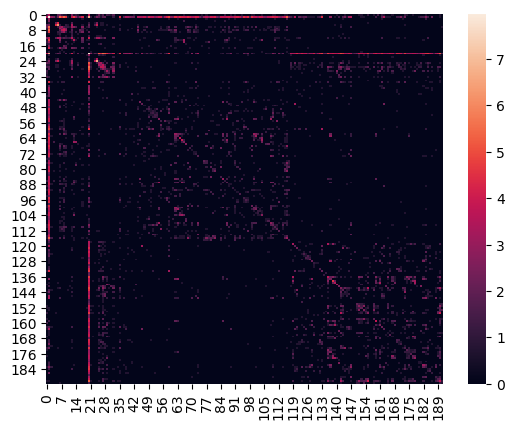

In [10]:
# if a file has already been selected, do not revert to no file selected
if not('M' in locals()):
    from dipy.tracking import utils
    #segment tractome into connectivity matrix from parcellation
    M, grouping=utils.connectivity_matrix(streamsObjIN.tractogram.streamlines, atlasImg.affine, label_volume=relabeledAtlas.astype(int),
                            return_mapping=True,
                            mapping_as_streamlines=False)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(np.log1p(M))
plt.show()

Now, lets use qgrid once more, but this time, you (the user) will be tasked with modifying the table in accordance with your segmentation goals.  In the table below, use the information in the column associated with anatomical terminology (if available) to select the labels that you wish to use as endpoint criteria for selecting streamlines.  Feel free to use the search functionality of the table by clicking the symbol beside a column's name.

To add a label to a either criteria "region1" or criteria "region2" place a value of **1** (as in the form of a **boolean vector** in the corresponding column.  The labels will be combined into "region1" and "region2" in accordance with this input, and (in the next cell) the ccoresponding streamlines will be displayed.

**Take care when making these entries as it can be easy to reset the jupyter cell type to "Markdown" when making this selection.  If this happens, reset the cell type to "Code" and rerun the cell"**

In [42]:
# if the length of the provided LUT exceeds the number of unique entries, then the indexes of the table cannot be relied
#upon to provide us with the correspondance to the relabeled atlas.  If this is the case, try and implement a workaround.
if len(LUT)>len(np.unique(relabeledAtlas)):
    #infer which column contains the original identities
    #presumably, this would be the LUT column with the largest number of matching labels with the original atlas.
    matchingLabelsCount=[len(list(set(LUT[iColumns]).intersection(set(np.unique(atlasImg.get_fdata()).astype(int))))) for iColumns in LUT.columns.to_list()]
    #there's an edge case here relabeled atlas == the original atlas AND the provided LUT was larger (what would the extra entries be?)
    #worry about that later
    columnBestGuess=LUT.columns.to_list()[matchingLabelsCount.index(np.max(matchingLabelsCount))]
    #now that we have the guess, get the corresponding row entries, and reset the index.
    #This should make the index match the renumbered label values.
    LUTinterface=LUT[LUT[columnBestGuess].isin(np.unique(atlasImg.get_fdata()).astype(int)).values].reset_index(drop=True)
    
#proceed with working with the LUT.  Here we add the columns for selecting labels for segmentation / streamline extraction.
if not("region1" in LUTinterface.columns):
    LUTinterface.insert(0, "region1", np.zeros([ len(LUTinterface),1],dtype=int), True)
if not("region2" in LUTinterface.columns):
    LUTinterface.insert(1, "region2", np.zeros([ len(LUTinterface),1],dtype=int), True)

seg_entryTable_widget=qgrid.show_grid(LUTinterface,show_toolbar=True)
seg_entryTable_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

To now perform the segmentation (after having made the above selection) run the next cell.  The streamlines displayed are those that have one endpoint in one the labels with 1 in the "region1" column and one endpoint in one the labels with 1 in the "region2" column.

**Remember**: the visualization starts fairly far out--be sure to zoom in.

In [47]:
#define a function that will be used to select streamlines from a larger tractogram
def extractSubTractogram(sourceTractogram,indexes):
    #import relevant package
    import nibabel as nib
    #extrect the desired streamlines into a new streamline object
    streamlines = sourceTractogram.streamlines[indexes]
    #establish tractogram object
    out_tractogram = nib.streamlines.tractogram.Tractogram(streamlines)
    return out_tractogram

segTable=seg_entryTable_widget.get_changed_df()
#check to make sure regions have actually be selected
if sum(segTable['region1'].values)>0 and sum(segTable['region2'].values)>0:
    #find the indexes for all of the labels that have been selected
    region1Indexes=segTable[segTable['region1']==1].index.to_list()
    region2Indexes=segTable[segTable['region2']==1].index.to_list()
    import itertools
    #find all of the combinations of the selected labels
    permutationsLabels = list(itertools.product(region1Indexes, region2Indexes))
    #create a flipped version of that (because we don't care about the orientation of the streamlines)
    flippedLabels= [x[::-1] for x in permutationsLabels]
    #combine those lists
    combinedLabels=permutationsLabels+flippedLabels
    #find the intersection of those combinations and the keys from the dipy tractome segmentation
    validKeys=list(set(grouping.keys()).intersection(set(combinedLabels)))
    #find the streamlines these connections correspond to
    validStreamList=[grouping[iConnections] for iConnections in validKeys]
    #convert that list of lists into a single list
    validStreamlines=list(itertools.chain.from_iterable(validStreamList))
    streamsToPlot=extractSubTractogram(streamsObjIN,validStreamlines)
    display(plotParcellationConnectionWidget(streamsToPlot))
else:
    print('either region1 or region2 lacks selected labels.  Return to previous selection cell and select labels for both regions.')

Plotting tractogram for all 5 streamlines.


interactive(children=(FloatSlider(value=39.74176788330078, continuous_update=False, description='threshold', m…

None

In [46]:
streamsToPlot.streamlines

ArraySequence([array([[10.4651375, 36.034332 ,  8.589023 ],
       [10.65086  , 35.37566  ,  9.317402 ],
       [10.83515  , 34.773483 , 10.091226 ],
       [11.018761 , 34.32679  , 10.965457 ],
       [11.119286 , 33.97766  , 11.896573 ],
       [11.114207 , 33.73025  , 12.86389  ],
       [10.999359 , 33.508743 , 13.8315735],
       [10.8562155, 33.21457  , 14.776329 ],
       [10.721183 , 32.810585 , 15.679682 ],
       [10.618377 , 32.302086 , 16.534117 ],
       [10.495177 , 31.661911 , 17.287382 ],
       [10.269471 , 30.939407 , 17.94032  ],
       [10.045673 , 30.181398 , 18.551239 ],
       [ 9.871142 , 29.323446 , 19.0308   ],
       [ 9.722102 , 28.393423 , 19.364655 ],
       [ 9.613212 , 27.448137 , 19.671528 ],
       [ 9.476477 , 26.564184 , 20.112633 ],
       [ 9.258484 , 25.770445 , 20.679678 ],
       [ 8.970458 , 24.94857  , 21.165913 ],
       [ 8.654316 , 24.087032 , 21.562943 ],
       [ 8.250837 , 23.310099 , 22.04022  ],
       [ 7.769926 , 22.6404   , 22.60559

Feel free to return to the selection cell, select different labels, and then visualize that new selection by running the previous code block.

Alternatively, continue on to modify

In [ ]:
#todo copy over sphere segmentation from WiMSE